# Significance Testing

**Not following Santer et al. (2008)**

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
import matplotlib as mpl
import xarray as xr
import numpy as np
import math as m
import scipy.stats as stats

In [2]:
data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

model_names       = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1'] #for loading areas
model_print_names = ['CanESM2', 'CESM1', 'CSIRO MK36', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1'] #for printing on graphs

member_numbers = [50, 40, 30, 20, 30, 100]

        # CanESM2, CESM1, CSIRO MK36, GFDL CM3, GFDL ESM2M, MPI ESM2
colors = ['m',     'b',   'g',        'orange',  'k',        'tab:olive' ]
obs_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

In [3]:
#load raw SIA data
#models
SIA = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

#observations
CDR  = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIA_SIE_CDR_BT_NT_79-20_filled.nc')
HadISST1 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_filled.nc')

#load resampling statistics
sigma_mem_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_10000.nc')
sigma_obs_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_obs_individual_10000.nc')

mu_mem_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_mem_individual_10000.nc')
mu_obs_individual = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_obs_individual_10000.nc')

In [14]:
SIA.rolling(dim='time', min_periods=42)

<xarray.Dataset>
Dimensions:     (member: 100, time: 3012)
Coordinates:
  * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * time        (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:0...
Data variables:
    CanESM2     (member, time) float32 ...
    CESM1       (member, time) float32 ...
    CSIRO_MK36  (member, time) float32 ...
    GFDL_CM3    (member, time) float32 ...
    GFDL_ESM2M  (member, time) float32 ...
    MPI_ESM1    (member, time) float32 ...
Attributes:
    Description:  Arctic sea ice area (SIA) for the large ensemble models: Ca...
    Units:        million square km
    Timestamp:    19:56 UTC Tue 2021-06-22
    Data source:  CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2
    Analysis:     https://github.com/chrisrwp/synthetic-ensemble/SIA/SIC_to_S...

## Simple t-tests

In [5]:
p_vals = []
for obs_data in ['CDR','NT','BT','HadISST1']:
    
    p_val_obs = []
    for model_i, model_name in enumerate(model_names):
        
        p_val_obs_model = []
        for month_ in np.arange(1,13):
            if model_name == 'MPI_ESM1': #MPI has the full 100 members so do not sel on member dimension
                model_sigmas = sigma_mem_individual[model_name].sel(month=month_)
            else:
                model_sigmas = sigma_mem_individual[model_name].sel(month=month_).sel(member=slice('1',str(member_numbers[model_i])))
                
            t_stat, p = stats.ttest_1samp(model_sigmas, sigma_obs_individual[obs_data].sel(month=month_))
                                          
            p_val_obs_model.append(p)
        p_val_obs.append(p_val_obs_model)
    p_vals.append(p_val_obs)
    
p_vals_xr = xr.DataArray(data=p_vals, coords={'obs_dataset':['CDR','NT','BT','HadISST1'], 'model':model_names,'month':np.arange(1,13)}, dims=['obs_dataset','model','month'])

p_vals_sig = p_vals_xr.where(p_vals_xr>0.05,0)
p_vals_sig = p_vals_sig.where(p_vals_sig<=0.05,1)

In [17]:
obs_datasets = ['CDR','NT','BT','HadISST1']
min_list = []
max_list = []

for month_ in np.arange(1,13):
    CDR_temp = sigma_obs_individual['CDR'].sel(month=month_).values
    NT_temp = sigma_obs_individual['NT'].sel(month=month_).values
    BT_temp = sigma_obs_individual['BT'].sel(month=month_).values
    HadISST1_temp = sigma_obs_individual['HadISST1'].sel(month=month_).values
    
    month_array = [CDR_temp, NT_temp, BT_temp, HadISST1_temp]
    min_list.append(np.argmin(month_array))
    max_list.append(np.argmax(month_array))

In [22]:
#minimum and maximum obs p_vals
p_vals_min = []
p_vals_max = []
for model_i, model_name in enumerate(model_names):

    p_val_model_min = []
    p_val_model_max = []
    for month_ in np.arange(1,13):
        if model_name == 'MPI_ESM1': #MPI has the full 100 members so do not sel on member dimension
            model_sigmas = sigma_mem_individual[model_name].sel(month=month_)
        else:
            model_sigmas = sigma_mem_individual[model_name].sel(month=month_).sel(member=slice('1',str(member_numbers[model_i])))

        #find the observational dataset with the minimum and maximum sigma_obs
        min_month = obs_datasets[min_list[month_-1]]
        max_month = obs_datasets[max_list[month_-1]]    
        
        #run the t-test
        t_stat_min, p_min = stats.ttest_1samp(model_sigmas, sigma_obs_individual[min_month].sel(month=month_))
        t_stat_max, p_max = stats.ttest_1samp(model_sigmas, sigma_obs_individual[max_month].sel(month=month_))

        p_val_model_min.append(p_min)
        p_val_model_max.append(p_max)
        
    p_vals_min.append(p_val_model_min)
    p_vals_max.append(p_val_model_max)

p_vals_min_xr = xr.DataArray(data=p_vals_min, coords={'model':model_names,'month':np.arange(1,13)}, dims=['model','month'])
p_vals_max_xr = xr.DataArray(data=p_vals_max, coords={'model':model_names,'month':np.arange(1,13)}, dims=['model','month'])

In [68]:
#make an xarray dataarray of higher or lower sigma_obs than bar_sigma_mem - binary -1 or 1
higher_lower = sigma_mem_individual.mean('member') - sigma_obs_individual.drop('SII').drop('Merged').to_array()
higher_lower = higher_lower.rename({'variable':'obs_dataset'})
higher_lower = higher_lower.where(higher_lower>0,-1)
higher_lower = higher_lower.where(higher_lower==-1,1)

In [72]:
min_obs_diff = []
max_obs_diff = []
for month_ in np.arange(1,13):
   
    min_obs_diff_model = []
    max_obs_diff_model = []
    for model_name in model_names:
        min_obs_diff_model.append(higher_lower[model_name].sel(obs_dataset=obs_datasets[min_list[month_-1]]).sel(month=month_))
        max_obs_diff_model.append(higher_lower[model_name].sel(obs_dataset=obs_datasets[max_list[month_-1]]).sel(month=month_))
        
    min_obs_diff.append(xr.concat((min_obs_diff_model),dim='model'))
    max_obs_diff.append(xr.concat((max_obs_diff_model),dim='model'))
    
min_obs_diff_xr = xr.concat((min_obs_diff),dim='month')
min_obs_diff_xr['month'] = np.arange(1,13)
min_obs_diff_xr['model'] = model_names

max_obs_diff_xr = xr.concat((max_obs_diff),dim='month')
max_obs_diff_xr['month'] = np.arange(1,13)
max_obs_diff_xr['model'] = model_names

In [5]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])
fig = plt.figure(figsize=[4.7,5.5]) 

plt.pcolor(min_obs_diff_xr.where(p_vals_min_xr<0.05,0).reindex(month=list(reversed(min_obs_diff_xr.month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-1, vmax=1)
plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short[::-1], fontsize=14);
plt.title(r'Minimum $\sigma_{obs}$', fontsize=16);

In [7]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])

fig = plt.figure(figsize=[4.7,5.5]) 

plt.pcolor(max_obs_diff_xr.where(p_vals_max_xr<0.05,0).reindex(month=list(reversed(max_obs_diff_xr.month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-1, vmax=1)
plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short[::-1], fontsize=14);
plt.title(r'Maximum $\sigma_{obs}$', fontsize=16);

In [6]:
fig = plt.figure(figsize=[4.7,5.5]) 

plt.pcolor(p_vals_xr.max('obs_dataset').transpose(), cmap='plasma', edgecolor='0.5', lw=2, norm=mpl.colors.LogNorm(1e-10, 1))
plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short, fontsize=14);
plt.colorbar()
plt.title('Highest p-value', fontsize=16);

In [8]:
#combine max and min
#-4=dark blue, -1=light blue, 2=Black, 3=Pink, 4=Red          -4                 -3              -2               -1          0        1         2           3             4
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.1, 0.1, 0.8), (0.1, 0.1, 0.8), (0.1, 0.1, 0.8), "1",     "1",      "0", (0.8, 0.1, 0.1), (0.8, 0.1, 0.1)])


fig = plt.figure(figsize=[4.5,5.5]) 

plt.pcolor((max_obs_diff_xr.where(p_vals_max_xr<0.05,0) + 3*min_obs_diff_xr.where(p_vals_min_xr<0.05,0)).reindex(month=list(reversed(max_obs_diff_xr.month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-4, vmax=4)
plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short[::-1], fontsize=14);
plt.title(r'Combined t-test $\sigma_{obs}$', fontsize=16);

In [10]:
#plot p-vales for a given obs dataset
fig = plt.figure(figsize=[4.7,5.5]) 

plt.pcolor(p_vals_xr.sel(obs_dataset='HadISST1').where(p_vals_xr.sel(obs_dataset='HadISST1')<0.05).transpose(), cmap='plasma', edgecolor='0.5', lw=2, norm=mpl.colors.LogNorm(1e-10, 0.05))
plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short, fontsize=14);
plt.colorbar()
plt.title('HadISST1 p-value', fontsize=16);

In [11]:
#sum up the number of consistnet and inconsistent obs datasets
fig = plt.figure(figsize=[5.5,5.5]) 

# bounds = np.array([0,1,2,3,4])
# norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=4)

plt.pcolor(p_vals_sig.sum('obs_dataset').transpose(), cmap='Greens_r', edgecolor='0.5', lw=2, vmin=0, vmax=4)
plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short, fontsize=14);
cbar = plt.colorbar(ticks=[0,1,2,3,4]);
cbar.ax.set_ylabel('Number of Observational Datasets', fontsize=16)
plt.title('Not Significantly Different', fontsize=16);

## Consistency of $\bar{\sigma}_{mem}$ standard deviations
**Color scale of above/beow and hatching for too far away**

In [4]:
fig, ax = plt.subplots(1,6,figsize=[20,5]) 

for model_i, model_name in enumerate(model_names):
    data_to_plot = (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')+2*sigma_mem_individual[model_name].std('member'))).transpose()

    plot_mesh = ax[model_i].pcolor(data_to_plot.reindex(month=list(reversed(data_to_plot.month))), cmap='RdBu_r', edgecolor='0.5', lw=2, vmin=-0.05, vmax=0.05)
    
    if model_i == 5:
        cbar_ax = fig.add_axes([0.15, 0, 0.7, 0.05])
    
        cbar = fig.colorbar(plot_mesh, cax=cbar_ax, ticks=np.arange(-0.05,0.06,0.01), orientation='horizontal')
        cbar.ax.set_xlabel(r'$\sigma_{obs} - (\bar{\sigma}_{mem} + 2 \sigma)$', fontsize=16)
        for t in cbar.ax.get_xticklabels():
             t.set_fontsize(15)

    ax[model_i].pcolor((data_to_plot.where(data_to_plot>0).reindex(month=list(reversed(data_to_plot.month)))), hatch='//', alpha=0.)

    ax[model_i].set_xticks(np.arange(0.5, 3.6, 1));
    ax[model_i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[model_i].set_xticklabels(['CDR','NT','BT','Had'], fontsize=14, rotation=0)
    
    if model_i == 0:
        ax[model_i].set_yticklabels(month_names_short[::-1], fontsize=14)
    else:
        ax[model_i].set_yticklabels(['','','','','','','','','','','',''], fontsize=14)
        
    ax[model_i].set_title(model_print_names[model_i], fontsize=16);

plt.subplots_adjust(wspace=0.05, top=0.85)
plt.suptitle(r'$\sigma_{obs}$ - (Ensemble mean + 2 Standard Deviation of $\sigma_{mem}$)', fontsize=22);

In [3]:
fig, ax = plt.subplots(1,6,figsize=[20,5]) 

for model_i, model_name in enumerate(model_names):
    data_to_plot = (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')-2*sigma_mem_individual[model_name].std('member'))).transpose()

    plot_mesh = ax[model_i].pcolor(data_to_plot.reindex(month=list(reversed(data_to_plot.month))), cmap='RdBu_r', edgecolor='0.5', lw=2, vmin=-0.05, vmax=0.05)
    
    if model_i == 5:
        cbar_ax = fig.add_axes([0.15, 0, 0.7, 0.05])
    
        cbar = fig.colorbar(plot_mesh, cax=cbar_ax, ticks=np.arange(-0.05,0.06,0.01), orientation='horizontal')
        cbar.ax.set_xlabel(r'$\sigma_{obs} - (\bar{\sigma}_{mem} - 2 \sigma)$', fontsize=16)
        for t in cbar.ax.get_xticklabels():
             t.set_fontsize(15)

    ax[model_i].pcolor((data_to_plot.where(data_to_plot<0).reindex(month=list(reversed(data_to_plot.month)))), hatch='//', alpha=0.)

    ax[model_i].set_xticks(np.arange(0.5, 3.6, 1));
    ax[model_i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[model_i].set_xticklabels(['CDR','NT','BT','Had'], fontsize=14, rotation=0)
    
    if model_i == 0:
        ax[model_i].set_yticklabels(month_names_short[::-1], fontsize=14)
    else:
        ax[model_i].set_yticklabels(['','','','','','','','','','','',''], fontsize=14)
        
    ax[model_i].set_title(model_print_names[model_i], fontsize=16);

plt.subplots_adjust(wspace=0.05, top=0.85)
plt.suptitle(r'$\sigma_{obs}$ - (Ensemble mean - 2 Standard Deviation of $\sigma_{mem}$)', fontsize=22);

## Make consistency plots with 'both'

In [2]:
#both
fig, ax = plt.subplots(1,6,figsize=[20,5]) 

for model_i, model_name in enumerate(model_names):
    
    SD_plus2  = (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')+2*sigma_mem_individual[model_name].std('member'))).transpose()
    SD_minus2 = (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')-2*sigma_mem_individual[model_name].std('member'))).transpose()
    
    both_true = xr.ufuncs.logical_and(SD_plus2>0, SD_minus2<0)
    

    data_plot = ax[model_i].pcolor(both_true.where(both_true==False), cmap='binary', edgecolor='0.5', lw=2)
    
    #unacceptably high
    
    ax[model_i].pcolor((sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')-2*sigma_mem_individual[model_name].std('member'))).transpose().where(
               (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')-2*sigma_mem_individual[model_name].std('member'))).transpose()<0).where(both_true==False), 
                       cmap='Reds', edgecolor='0.5', lw=2, vmin=-999, vmax=-998)
    
    ((SD_plus2.where(SD_plus2>0))*0)+1
    
    #unacceptably low
    ax[model_i].pcolor((sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')+2*sigma_mem_individual[model_name].std('member'))).transpose().where(
               (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')+2*sigma_mem_individual[model_name].std('member'))).transpose()>0).where(both_true==False), 
                       cmap='Blues', edgecolor='0.5', lw=2, vmin=-999, vmax=-998)
  
    ax[model_i].set_xticks(np.arange(0.5, 3.6, 1));
    ax[model_i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[model_i].set_xticklabels(['CDR','NT','BT','Had'], fontsize=14, rotation=0)
    
    if model_i == 0:
        ax[model_i].set_yticklabels(month_names_short, fontsize=14)
    else:
        ax[model_i].set_yticklabels(['','','','','','','','','','','',''], fontsize=14)
        
    ax[model_i].set_title(model_print_names[model_i], fontsize=16);

plt.subplots_adjust(wspace=0.05, top=0.85)
# plt.suptitle(r'Observational Dataset - (Ensemble mean - 2 Standard Deviations of $\sigma_{mem}$)', fontsize=22);

In [488]:
SD_plus2_xr = []
SD_minus2_xr = []
for model_i, model_name in enumerate(model_names):

    SD_plus2  = (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')+1.65*sigma_mem_individual[model_name].std('member'))).transpose()
    SD_minus2 = (sigma_obs_individual.drop('SII').drop('Merged').to_array() - (sigma_mem_individual[model_name].mean('member')-1.65*sigma_mem_individual[model_name].std('member'))).transpose()

    SD_plus2_valid = SD_plus2.where(SD_plus2>0,0)
    SD_plus2_xr.append(SD_plus2_valid.where(SD_plus2_valid==0,1))

    SD_minus2_valid = SD_plus2.where(SD_minus2<0,0)
    SD_minus2_xr.append(SD_minus2_valid.where(SD_minus2_valid==0,1))
    
SD_plus2_xr = xr.concat((SD_plus2_xr), dim='model').sum('variable').transpose()
SD_plus2_xr['model'] = model_names
    
SD_minus2_xr = xr.concat((SD_minus2_xr), dim='model').sum('variable').transpose()
SD_minus2_xr['model'] = model_names

In [1]:
                                                   #white black             red          
cmap_red  = mpl.colors.LinearSegmentedColormap.from_list("",["1", "0", "0", "0", (0.8, 0.1, 0.1)])
                                                    #white black             blue          
cmap_blue = mpl.colors.LinearSegmentedColormap.from_list("",["1", "0", "0", "0", (0.1, 0.1, 0.8)])

fig = plt.figure(figsize=[4.5,5.5])

plt.pcolor(SD_plus2_xr.where(SD_plus2_xr>0).reindex(month=list(reversed(SD_plus2_xr.month))), cmap=cmap_blue, vmin=0, vmax=4, edgecolor='0.5', lw=2)
plt.pcolor(SD_minus2_xr.where(SD_minus2_xr>0).reindex(month=list(reversed(SD_minus2_xr.month))), cmap=cmap_red, vmin=0, vmax=4, edgecolor='0.5', lw=2)
# plt.pcolor((SD_minus2_xr<0).where(SD_plus2_xr<0).reindex(month=list(reversed(SD_minus2_xr.month))), cmap='binary', edgecolor='0.5', lw=2)

plt.pcolor(SD_plus2_xr.where(SD_plus2_xr==0).where(SD_minus2_xr==0).reindex(month=list(reversed(SD_plus2_xr.month))), cmap='binary', edgecolor='0.5', lw=2)


plt.xticks(np.arange(0.5, 5.6, 1), labels=model_print_names, fontsize=14, rotation=90);
plt.yticks(np.arange(0.5, 11.6, 1), labels=month_names_short.copy()[::-1],fontsize=14);

## 2 tailed confidence intervals on LE data for $\bar{\sigma}_{mem}$ and $\bar{\mu}_{mem}$

In [4]:
def confidence_interval(data, alpha):
    
    data = data[~np.isnan(data)]
    n    = len(data)-1
    
    mu_max = stats.t.ppf(1-(alpha*0.5), n, loc=np.mean(data), scale=np.std(data))
    mu_min = stats.t.ppf(alpha*0.5, n, loc=np.mean(data), scale=np.std(data))
    
    return(mu_min, mu_max)

In [5]:
sig_95_low = {}
sig_95_high = {}
for model_name in model_names:
    
    sig_95_low_month = []
    sig_95_high_month = []
    for month_ in np.arange(1,13):
        ci_temp = confidence_interval(sigma_mem_individual[model_name].sel(month=month_), 0.05)
        sig_95_low_month.append(ci_temp[0])
        sig_95_high_month.append(ci_temp[1])
    
    sig_95_low[model_name] = xr.DataArray(data=sig_95_low_month, coords={'month':np.arange(1,13)}, dims=['month'])
    sig_95_high[model_name] = xr.DataArray(data=sig_95_high_month, coords={'month':np.arange(1,13)}, dims=['month'])
    
sig_95_low = xr.Dataset(sig_95_low)
sig_95_high = xr.Dataset(sig_95_high)

In [6]:
mu_95_low = {}
mu_95_high = {}
for model_name in model_names:
    
    mu_95_low_month = []
    mu_95_high_month = []
    for month_ in np.arange(1,13):
        ci_temp = confidence_interval(mu_mem_individual[model_name].sel(month=month_), 0.05)
        mu_95_low_month.append(ci_temp[0])
        mu_95_high_month.append(ci_temp[1])
    
    mu_95_low[model_name] = xr.DataArray(data=mu_95_low_month, coords={'month':np.arange(1,13)}, dims=['month'])
    mu_95_high[model_name] = xr.DataArray(data=mu_95_high_month, coords={'month':np.arange(1,13)}, dims=['month'])
    
mu_95_low = xr.Dataset(mu_95_low)
mu_95_high = xr.Dataset(mu_95_high)

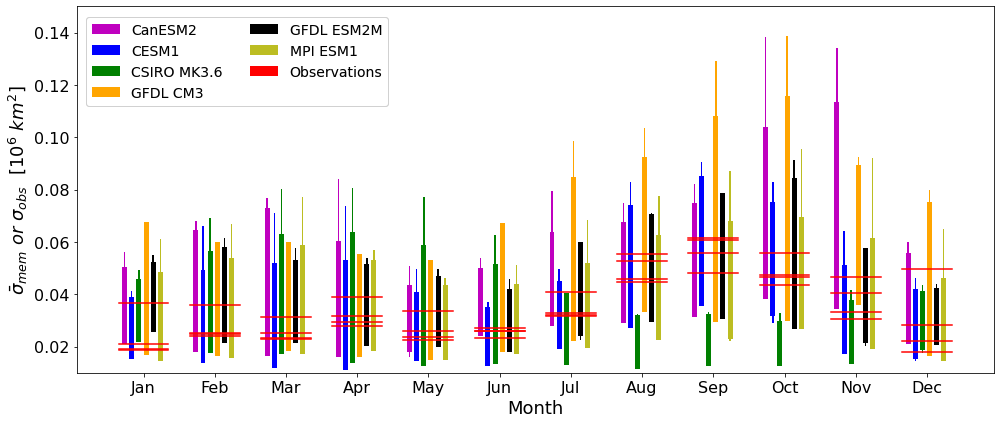

In [7]:
fig = plt.figure(figsize=[14,6])

sigma_mu = 'sigma'

if sigma_mu == 'sigma':
    high_95 = sig_95_high
    low_95  = sig_95_low
    mem_ind = sigma_mem_individual.copy()
    obs_ind = sigma_obs_individual
else:
    high_95 = mu_95_high
    low_95  = mu_95_low
    mem_ind = mu_mem_individual.copy()
    obs_ind = mu_obs_individual


for model_i, model_name in enumerate(model_names):
    plt.bar(np.arange(0.735+model_i*0.1,12.735+model_i*0.1,1),high_95[model_name]-low_95[model_name], bottom=low_95[model_name], color=colors[model_i], width=0.07)
    plt.bar(np.arange(0.735+model_i*0.1,12.735+model_i*0.1,1),mem_ind[model_name].max('member')-mem_ind[model_name].min('member'), 
            bottom=mem_ind[model_name].min('member'), color=colors[model_i], width=0.02)

for obs_dataset in ['CDR','BT','NT','HadISST1']:
    plt.plot([np.arange(0.65,12), np.arange(1.35,12.7)], [obs_ind[obs_dataset], obs_ind[obs_dataset]], c='r', linewidth=1.5)
    
legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK3.6'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),
                   Patch(facecolor='r', label='Observations')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(0.01, 0.97), loc='upper left', borderaxespad=0, ncol=2, fontsize=14)
plt.gca().add_artist(extra_legend);
    
plt.xticks(np.arange(1,13), labels=month_names_short, fontsize=16)
plt.xlabel('Month', fontsize=18)
plt.yticks(fontsize=16)

if sigma_mu == 'sigma':
    plt.ylim(0.01,0.15) #for sigma
    plt.ylabel(r'$\bar{\sigma}_{mem} \ or \ \sigma_{obs} \ \ [10^6 \ km^2]$', fontsize=18);
else:
    plt.ylim(0.1,0.85) #for mu
    plt.ylabel(r'$\bar{\mu}_{mem} \ or \ \mu_{obs} \ \ [10^6 \ km^2]$', fontsize=18);
    
plt.tight_layout()

In [56]:
skews = {}
all_skews = []
for model_name in model_names:
    month_skews = []
    for month_ in np.arange(1,13):
        month_skews.append(stats.skew(sigma_mem_individual[model_name].sel(month=month_), nan_policy='omit')*1)
        all_skews.append(stats.skew(sigma_mem_individual[model_name].sel(month=month_), nan_policy='omit')*1)
    
    skews[model_name] = month_skews

In [42]:
np.mean(all_skews)

0.31184526438964355

In [57]:
np.where(np.array(all_skews)<=0,0,1).sum() / len(all_skews)

0.9444444444444444

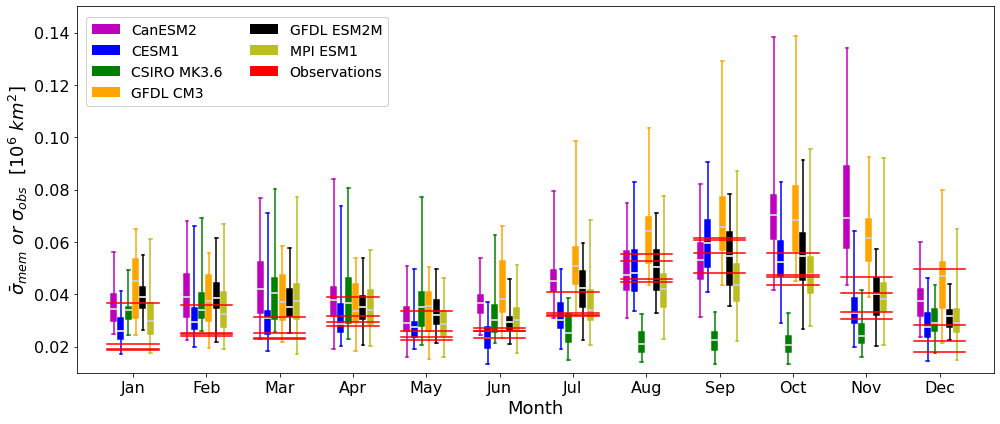

In [232]:
sigma_mu = 'sigma'

if sigma_mu == 'sigma':
    mem = sigma_mem_individual.copy()
    obs = sigma_obs_individual.to_array().sel(variable=['CDR','BT','NT','HadISST1'])
else:
    mem = mu_mem_individual.copy()
    obs = mu_obs_individual.to_array().sel(variable=['CDR','BT','NT','HadISST1'])

fig = plt.figure(figsize=[14,6])

for model_i, model_name in enumerate(model_names):
    boxplot_model = np.empty((member_numbers[model_i],12))
    
    for memb_i, memb in enumerate(np.arange(1,member_numbers[model_i]+1)):    
        boxplot_model[memb_i] = mem[model_name].sel(member=memb).values
    
    b_plot = plt.boxplot(boxplot_model, widths=0.07, positions=np.arange(0.735+model_i*0.1,12.735+model_i*0.1,1), 
                         whis=(0,100), labels=month_names_short, patch_artist=True);
    
    #set the colors
    for patch in b_plot['boxes']: 
        patch.set_facecolor(colors[model_i]) 
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(b_plot[element], color=colors[model_i], linewidth=1.5)
        
    plt.setp(b_plot['medians'], color='0.8', linewidth=2)
    
marker_list = ['o',8,9,'d','s']
for var_i in range(4):
    for month_ in np.arange(1,13):
        plt.plot([-0.35+month_, 0.35+month_], [obs.isel(variable=var_i).sel(month=month_), obs.isel(variable=var_i).sel(month=month_)], c='r', alpha=1, zorder=9)
#     plt.scatter(np.arange(0.6,12.6), obs.isel(variable=var_i), c='r', marker=marker_list[var_i])

legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK3.6'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),
                   Patch(facecolor='r', label='Observations')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(0.01, 0.97), loc='upper left', borderaxespad=0, ncol=2, fontsize=14)
plt.gca().add_artist(extra_legend);
    
plt.xticks(np.arange(1,13), fontsize=16)
plt.xlabel('Month', fontsize=18)
plt.yticks(fontsize=16)

if sigma_mu == 'sigma':
    plt.ylim(0.01,0.15) #for sigma
    plt.ylabel(r'$\bar{\sigma}_{mem} \ or \ \sigma_{obs} \ \ [10^6 \ km^2]$', fontsize=18);
else:
    plt.ylim(0.1,0.85) #for mu
    plt.ylabel(r'$\bar{\mu}_{mem} \ or \ \mu_{obs} \ \ [10^6 \ km^2]$', fontsize=18);

plt.tight_layout()

In [8]:
obs_consistent_sigma = {}
for model_name in model_names:
    
    cons_dataset = []
    for obs_dataset in ['CDR','BT','NT','HadISST1']:
    
        cons_month = []
        for month_ in np.arange(1,13):
            sig_obs = sigma_obs_individual[obs_dataset].sel(month=month_)
     
            #find out if model is too low
            if sig_obs.values > sig_95_high[model_name].sel(month=month_).values:
                cons_month.append(-1)
            #find out if model is too high
            elif sig_obs.values < sig_95_low[model_name].sel(month=month_).values:
                cons_month.append(1)
            #if not too high or low, then consistent
            else:
                cons_month.append(0)
        
        cons_dataset.append(cons_month)
    
    obs_consistent_sigma[model_name] = xr.DataArray(data=cons_dataset, coords={'dataset':['CDR','BT','NT','HadISST1'], 'month':np.arange(1,13)}, dims=['dataset','month'])
obs_consistent_sigma = xr.Dataset(obs_consistent_sigma)

In [9]:
obs_consistent_mu = {}
for model_name in model_names:
    
    cons_dataset = []
    for obs_dataset in ['CDR','BT','NT','HadISST1']:
    
        cons_month = []
        for month_ in np.arange(1,13):
            mu_obs = mu_obs_individual[obs_dataset].sel(month=month_)
     
            #find out if model is too low
            if mu_obs.values > mu_95_high[model_name].sel(month=month_).values:
                cons_month.append(-1)
            #find out if model is too high
            elif mu_obs.values < mu_95_low[model_name].sel(month=month_).values:
                cons_month.append(1)
            #if not too high or low, then consistent
            else:
                cons_month.append(0)
        
        cons_dataset.append(cons_month)
    
    obs_consistent_mu[model_name] = xr.DataArray(data=cons_dataset, coords={'dataset':['CDR','BT','NT','HadISST1'], 'month':np.arange(1,13)}, dims=['dataset','month'])
obs_consistent_mu = xr.Dataset(obs_consistent_mu)

In [10]:
red_sigma  = (obs_consistent_sigma.sum('dataset')==4)*1
blue_sigma = (obs_consistent_sigma.sum('dataset')==-4)*-1
white_sigma = xr.ufuncs.logical_and(xr.ufuncs.logical_and(obs_consistent_sigma.sel(dataset='CDR')==0, obs_consistent_sigma.sel(dataset='BT')==0),
                              xr.ufuncs.logical_and(obs_consistent_sigma.sel(dataset='NT')==0, obs_consistent_sigma.sel(dataset='HadISST1')==0))
black_sigma = xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_sigma,blue_sigma), white_sigma))

red_mu  = (obs_consistent_mu.sum('dataset')==4)*1
blue_mu = (obs_consistent_mu.sum('dataset')==-4)*-1
white_mu = xr.ufuncs.logical_and(xr.ufuncs.logical_and(obs_consistent_mu.sel(dataset='CDR')==0, obs_consistent_mu.sel(dataset='BT')==0),
                              xr.ufuncs.logical_and(obs_consistent_mu.sel(dataset='NT')==0, obs_consistent_mu.sel(dataset='HadISST1')==0))
black_mu = xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_mu,blue_mu), white_mu))
                            

### Combine into equivalent for Figure 8 -  g,h,i

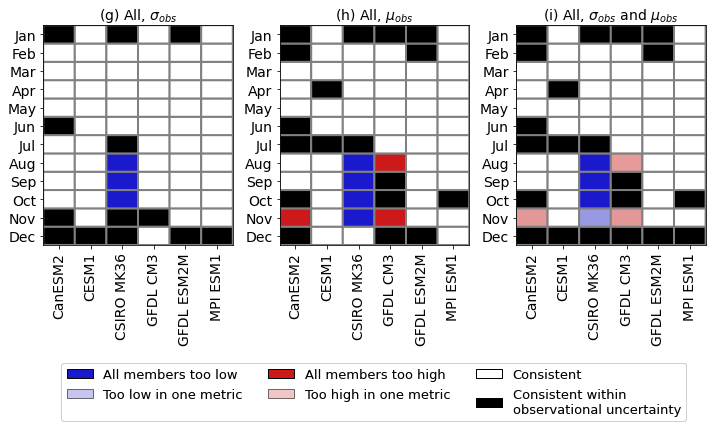

In [11]:
titles = ['(g) All, $\sigma_{obs}$', '(h) All, $\mu_{obs}$', 
          '(i) All, $\sigma_{obs}$ and $\mu_{obs}$']

# cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])
# cmap_gray = mpl.colors.LinearSegmentedColormap.from_list("", ["0","w"])

cmap_g_h = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), "0", (0.8, 0.1, 0.1), "1"])
cmap_i = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"0",(0.9, 0.6, 0.6),"0",(0.9, 0.6, 0.6), "1"])
camp_list = [cmap_g_h, cmap_g_h, cmap_i]
cmap_min_max = [[-1,2],[-1,2],[-2,4]]

data_g = (red_sigma+blue_sigma+(white_sigma*2)).to_array().reindex(month=list(reversed(red_sigma.month))).transpose()
data_h = (red_mu+blue_mu+(white_mu*2)).to_array().reindex(month=list(reversed(red_mu.month))).transpose()
data_i = ((red_sigma+blue_sigma+(white_sigma*2)) + (red_mu+blue_mu+(white_mu*2))).to_array().reindex(month=list(reversed(red_sigma.month))).transpose()
all_data_list = [data_g, data_h, data_i]

#do the plotting
fig, ax = plt.subplots(1,3,figsize=[10,5]) 

for i in range(3):
    ax[i].pcolor(all_data_list[i], cmap=camp_list[i], edgecolor='0.5', lw=2, vmin=cmap_min_max[i][0], vmax=cmap_min_max[i][1])
    # ax[i].pcolor(xr.ufuncs.isnan(all_data_CDR_Had[i]).where(xr.ufuncs.isnan(all_data_CDR_Had[i])==True).reindex(month=list(reversed(both.month))), cmap=cmap_gray, edgecolor='0.5', lw=2)
    ax[i].set_xticks(np.arange(0.5, 5.6, 1));
    ax[i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[i].set_xticklabels(model_print_names, fontsize=14,rotation = 90);
    ax[i].set_yticklabels(month_names_short.copy()[::-1], fontsize=14);
    ax[i].set_title(titles[i], fontdict={'size':14});#, 'weight':'bold'});

legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.6, 0.6, 0.9), ec='0', alpha=0.5, label='Too low in one metric'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor=(0.9, 0.6, 0.6), ec='0', alpha=0.5, label='Too high in one metric'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.75, -0.8), loc='lower center', borderaxespad=0., ncol=3, fontsize=13)

plt.gca().add_artist(extra_legend)    
    
    
plt.tight_layout();
plt.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_95CI_agree.pdf', bbox_inches='tight')

## Use subsampled data for 20 members

In [22]:
#load the bootstrapped data
sigma_mem_subsample_20_min = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/subsample_20_members_1000_sigma_mem_min.nc')
sigma_mem_subsample_20_max = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/subsample_20_members_1000_sigma_mem_max.nc')

mu_mem_subsample_20_min = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/subsample_20_members_1000_mu_mem_min.nc')
mu_mem_subsample_20_max = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/subsample_20_members_1000_mu_mem_max.nc')

In [28]:
obs_consistent_sigma = {}
for model_name in model_names:
    
    cons_dataset = []
    for obs_dataset in ['CDR','BT','NT','HadISST1']:
    
        cons_month = []
        for month_ in np.arange(1,13):
            sig_obs = sigma_obs_individual[obs_dataset].sel(month=month_)
     
            #find out if model is too low
            if sig_obs.values > sigma_mem_subsample_20_max[model_name].sel(month=month_).values:
                cons_month.append(-1)
            #find out if model is too high
            elif sig_obs.values < sigma_mem_subsample_20_min[model_name].sel(month=month_).values:
                cons_month.append(1)
            #if not too high or low, then consistent
            else:
                cons_month.append(0)
        
        cons_dataset.append(cons_month)
    
    obs_consistent_sigma[model_name] = xr.DataArray(data=cons_dataset, coords={'dataset':['CDR','BT','NT','HadISST1'], 'month':np.arange(1,13)}, dims=['dataset','month'])
obs_consistent_sigma = xr.Dataset(obs_consistent_sigma)

In [29]:
obs_consistent_mu = {}
for model_name in model_names:
    
    cons_dataset = []
    for obs_dataset in ['CDR','BT','NT','HadISST1']:
    
        cons_month = []
        for month_ in np.arange(1,13):
            mu_obs = mu_obs_individual[obs_dataset].sel(month=month_)
     
            #find out if model is too low
            if mu_obs.values > mu_mem_subsample_20_max[model_name].sel(month=month_).values:
                cons_month.append(-1)
            #find out if model is too high
            elif mu_obs.values < mu_mem_subsample_20_min[model_name].sel(month=month_).values:
                cons_month.append(1)
            #if not too high or low, then consistent
            else:
                cons_month.append(0)
        
        cons_dataset.append(cons_month)
    
    obs_consistent_mu[model_name] = xr.DataArray(data=cons_dataset, coords={'dataset':['CDR','BT','NT','HadISST1'], 'month':np.arange(1,13)}, dims=['dataset','month'])
obs_consistent_mu = xr.Dataset(obs_consistent_mu)

In [30]:
red_sigma  = (obs_consistent_sigma.sum('dataset')==4)*1
blue_sigma = (obs_consistent_sigma.sum('dataset')==-4)*-1
white_sigma = xr.ufuncs.logical_and(xr.ufuncs.logical_and(obs_consistent_sigma.sel(dataset='CDR')==0, obs_consistent_sigma.sel(dataset='BT')==0),
                              xr.ufuncs.logical_and(obs_consistent_sigma.sel(dataset='NT')==0, obs_consistent_sigma.sel(dataset='HadISST1')==0))
black_sigma = xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_sigma,blue_sigma), white_sigma))

red_mu  = (obs_consistent_mu.sum('dataset')==4)*1
blue_mu = (obs_consistent_mu.sum('dataset')==-4)*-1
white_mu = xr.ufuncs.logical_and(xr.ufuncs.logical_and(obs_consistent_mu.sel(dataset='CDR')==0, obs_consistent_mu.sel(dataset='BT')==0),
                              xr.ufuncs.logical_and(obs_consistent_mu.sel(dataset='NT')==0, obs_consistent_mu.sel(dataset='HadISST1')==0))
black_mu = xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_mu,blue_mu), white_mu))
                            

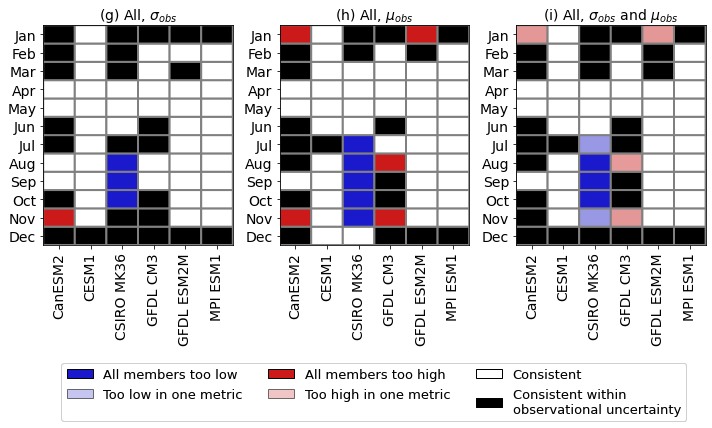

In [31]:
titles = ['(g) All, $\sigma_{obs}$', '(h) All, $\mu_{obs}$', 
          '(i) All, $\sigma_{obs}$ and $\mu_{obs}$']

# cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])
# cmap_gray = mpl.colors.LinearSegmentedColormap.from_list("", ["0","w"])

cmap_g_h = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), "0", (0.8, 0.1, 0.1), "1"])
cmap_i = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"0",(0.9, 0.6, 0.6),"0",(0.9, 0.6, 0.6), "1"])
camp_list = [cmap_g_h, cmap_g_h, cmap_i]
cmap_min_max = [[-1,2],[-1,2],[-2,4]]

data_g = (red_sigma+blue_sigma+(white_sigma*2)).to_array().reindex(month=list(reversed(red_sigma.month))).transpose()
data_h = (red_mu+blue_mu+(white_mu*2)).to_array().reindex(month=list(reversed(red_mu.month))).transpose()
data_i = ((red_sigma+blue_sigma+(white_sigma*2)) + (red_mu+blue_mu+(white_mu*2))).to_array().reindex(month=list(reversed(red_sigma.month))).transpose()
all_data_list = [data_g, data_h, data_i]

#do the plotting
fig, ax = plt.subplots(1,3,figsize=[10,5]) 

for i in range(3):
    ax[i].pcolor(all_data_list[i], cmap=camp_list[i], edgecolor='0.5', lw=2, vmin=cmap_min_max[i][0], vmax=cmap_min_max[i][1])
    # ax[i].pcolor(xr.ufuncs.isnan(all_data_CDR_Had[i]).where(xr.ufuncs.isnan(all_data_CDR_Had[i])==True).reindex(month=list(reversed(both.month))), cmap=cmap_gray, edgecolor='0.5', lw=2)
    ax[i].set_xticks(np.arange(0.5, 5.6, 1));
    ax[i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[i].set_xticklabels(model_print_names, fontsize=14,rotation = 90);
    ax[i].set_yticklabels(month_names_short.copy()[::-1], fontsize=14);
    ax[i].set_title(titles[i], fontdict={'size':14});#, 'weight':'bold'});

legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.6, 0.6, 0.9), ec='0', alpha=0.5, label='Too low in one metric'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor=(0.9, 0.6, 0.6), ec='0', alpha=0.5, label='Too high in one metric'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.75, -0.8), loc='lower center', borderaxespad=0., ncol=3, fontsize=13)

plt.gca().add_artist(extra_legend)    
    
    
plt.tight_layout();